In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision import transforms

import numpy as np
import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

In [ ]:
# Download data
transform = transforms.Compose(
    [transforms.Resize(224),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

batch_size = 32

trainset = torchvision.datasets.CIFAR100(root='./data', train=True,
                                        download=True, transform=transform)
train_dataloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, 
                                              shuffle=True, num_workers=2)
testset = torchvision.datasets.CIFAR100(root='./data', train=False,
                                       download=True, transform=transform)
test_dataloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                              shuffle=False, num_workers=2)

  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
class_names = ('beaver', 'dolphin', 'otter', 'seal', 'whale',
               'aquarium fish', 'flatfish', 'ray', 'shark', 'trout',
               'orchids', 'poppies', 'roses', 'sunflowers', 'tulips',
               'bottles', 'bowls', 'cans', 'cups', 'plates',
               'apples', 'mushrooms', 'oranges', 'pears', 'sweet peppers',
               'clock', 'computer keyboard', 'lamp', 'telephone', 'television',
               'bed', 'chair', 'couch', 'table', 'wardrobe',
               'bee', 'beetle', 'butterfly', 'caterpillar', 'cockroach',
               'bear', 'leopard', 'lion', 'tiger', 'wolf',
               'bridge', 'castle', 'house', 'road', 'skyscraper',
               'cloud', 'forest', 'mountain', 'plain', 'sea',
               'camel', 'cattle', 'chimpanzee', 'elephant', 'kangaroo',
               'fox', 'porcupine', 'possum', 'raccoon', 'skunk',
               'crab', 'lobster', 'snail', 'spider', 'worm',
               'baby', 'boy', 'girl', 'man', 'woman',
               'crocodile', 'dinosaur', 'lizard', 'snake', 'turtle',
               'hamster', 'mouse', 'rabbit', 'shrew', 'squirrel',
               'maple', 'oak', 'palm', 'pine', 'willow',
               'bicycle', 'bus', 'motorcycle', 'pickup truck', 'train',
               'lawn-mower', 'rocket', 'streetcar', 'tank', 'tractor')

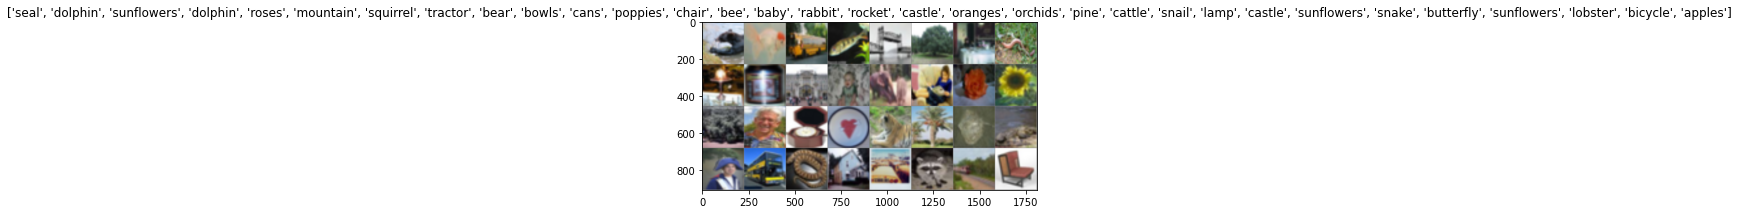

In [ ]:
def imshow(inp, title=None):
  """Imshow for Tensor."""
  inp = inp.numpy().transpose((1, 2, 0))
  mean = np.array([0.5, 0.5, 0.5])
  std = np.array([0.5, 0.5, 0.5])
  inp = std * inp + mean
  inp = np.clip(inp, 0, 1)
  plt.imshow(inp)
  if title is not None:
    plt.title(title)
  plt.pause(0.001) # Pause so that plots are updated

# Get a batch of training data
inputs, classes = next(iter(train_dataloader))

# Make a grid from the batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [ ]:
def train(dataloader, model, loss_fn, optimizer, device):
  model.train() # set model to train model
  for step, (x, y) in enumerate(dataloader): 
    # send data to GPU or CPU
    x = x.to(device)
    y = y.to(device)
    
    # feed the data to the model
    pred = model(x)
    
    # compute the loss
    loss = loss_fn(pred, y)
    
    # backpropagation (update the parameters)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # calculate f1 score
    pred = pred.argmax(axis=1) 
    score = f1_score(y.detach().cpu().numpy(), pred.detach().cpu().numpy(), average="macro")

    if step % 200 == 0: 
      loss  = loss.item()
      print('Current Step: %d, loss:%.4f' %(step, loss))
      print('F1 Score:%.4f' %score)
      

In [ ]:
def test(dataloader, model, loss_fn, device):
  num_batch = len(dataloader)

  model.eval()
  test_loss = 0
  correct = 0

  with torch.no_grad():
    for x, y in dataloader:
      x = x.to(device)
      y = y.to(device)
      pred = model(x)
      loss = loss_fn(pred, y)
      test_loss += loss.item()
      
      y_hat = pred.argmax(1)
      correct_batch = (y_hat == y).type(torch.float).sum().item()
      correct += correct_batch

      # calculate f1 score
      pred = pred.argmax(axis=1) 
      score = f1_score(y.detach().cpu().numpy(), pred.detach().cpu().numpy(), average="macro")
      
  test_loss /= num_batch
  correct = correct / (num_batch * batch_size)
  
  print("Test Accuracy:%.4f" % correct)
  print("F1 Score:%4f" % score)

#### PyTorch Pre-build DenseNet

In [ ]:
import torchvision.models as models
model = models.densenet161(pretrained=False)
# print(model)
for p in model.parameters():
  p.require_grad=True
num_ftrs = model.classifier.in_features
model.fc = nn.Linear(num_ftrs, 100)

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = model.to(device)
# print(model)

# Optimizing the model parameter
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)

# Train model in epochs
epochs = 5
for t in tqdm.tqdm(range(epochs)):
  print('Epoch %d \n----------------' %t)
  train(train_dataloader, model, loss_fn, optimizer, device)
  test(test_dataloader, model, loss_fn, device)
print("Done!")

#### DenseNet Transfer Learning

In [ ]:
# import torchvision.models as models
# model = models.densenet161(pretrained=True)
# for p in model.parameters():
#   p.require_grad=True
# num_ftrs = model.classifier.in_features
# model.fc = nn.Linear(num_ftrs, 100)

In [ ]:
# device = "cuda" if torch.cuda.is_available() else "cpu"

# model = model.to(device)
# print(model)

# # Optimizing the model parameter
# loss_fn = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)

# # Train model in epochs
# epochs = 5
# for t in tqdm.tqdm(range(epochs)):
#   print('Epoch %d \n----------------' %t)
#   train(train_dataloader, model, loss_fn, optimizer, device)
# #   test(test_dataloader, model, loss_fn, device)
# print("Done!")